# 算法原理

LightGBM是基于XGB进行改进的，这是它主要的比较对象，所以我们先说一下XGB有哪些优缺点。


XGB优点：

- XGB利用了二阶梯度来对节点进行划分，相对其他GBM来说，精度更加高。

- 利用局部近似算法对分裂节点的贪心算法优化，取适当的eps时，可以保持算法的性能且提高算法的运算速度。

- 在损失函数中加入了L1/L2项，控制模型的复杂度，提高模型的鲁棒性。

- 提供并行计算能力，主要是在树节点求不同的候选的分裂点的Gain Infomation（分裂后，损失函数的差值）

- Tree Shrinkage，column subsampling等不同的处理细节。

XGB缺点：

- 需要pre-sorted，这个会耗掉很多的内存空间（2×#data×#features）

- 数据分割点上，由于XGB对不同的数据特征使用pre-sorted算法而不同特征其排序顺序是不同的，所以分裂时需要对每个特征单独做依次分割，遍历次数为#data×#features来将数据分裂到左右子节点上。

- 尽管使用了局部近似计算，但是处理粒度还是太细了

- 由于pre-sorted处理数据，在寻找特征分裂点时（level-wise），会产生大量的cache随机访问。



LightGBM就针对以上缺点进行了改进，原文的解释如下。

- LightGBM使用基于histogram算法代替了pre-sorted算法构建的数据结构。利用histogram后，会有很多好处。例如histogram做差，提高了cache命中率（因为使用了leaf-wise）。

- LightGBM采用GOSS来做数据采样，提高了训练速度。类似于Adaboost在数据训练时赋予样本权重。

- 采用EFB算法来预处理稀疏数据，解决了histogram算法对稀疏数据的处理时间复杂度差于pre-sorted的问题

**基于Histogram的决策树算法**  

(1)直方图算法

Histogram algorithm应该翻译为直方图算法，直方图算法的基本思想是：先把连续的浮点特征值离散化成k个整数，同时构造一个宽度为k的直方图。在遍历数据的时候，根据离散化后的值作为索引在直方图中累计统计量，当遍历一次数据后，直方图累积了需要的统计量，然后根据直方图的离散值，遍历寻找最优的分割点。  

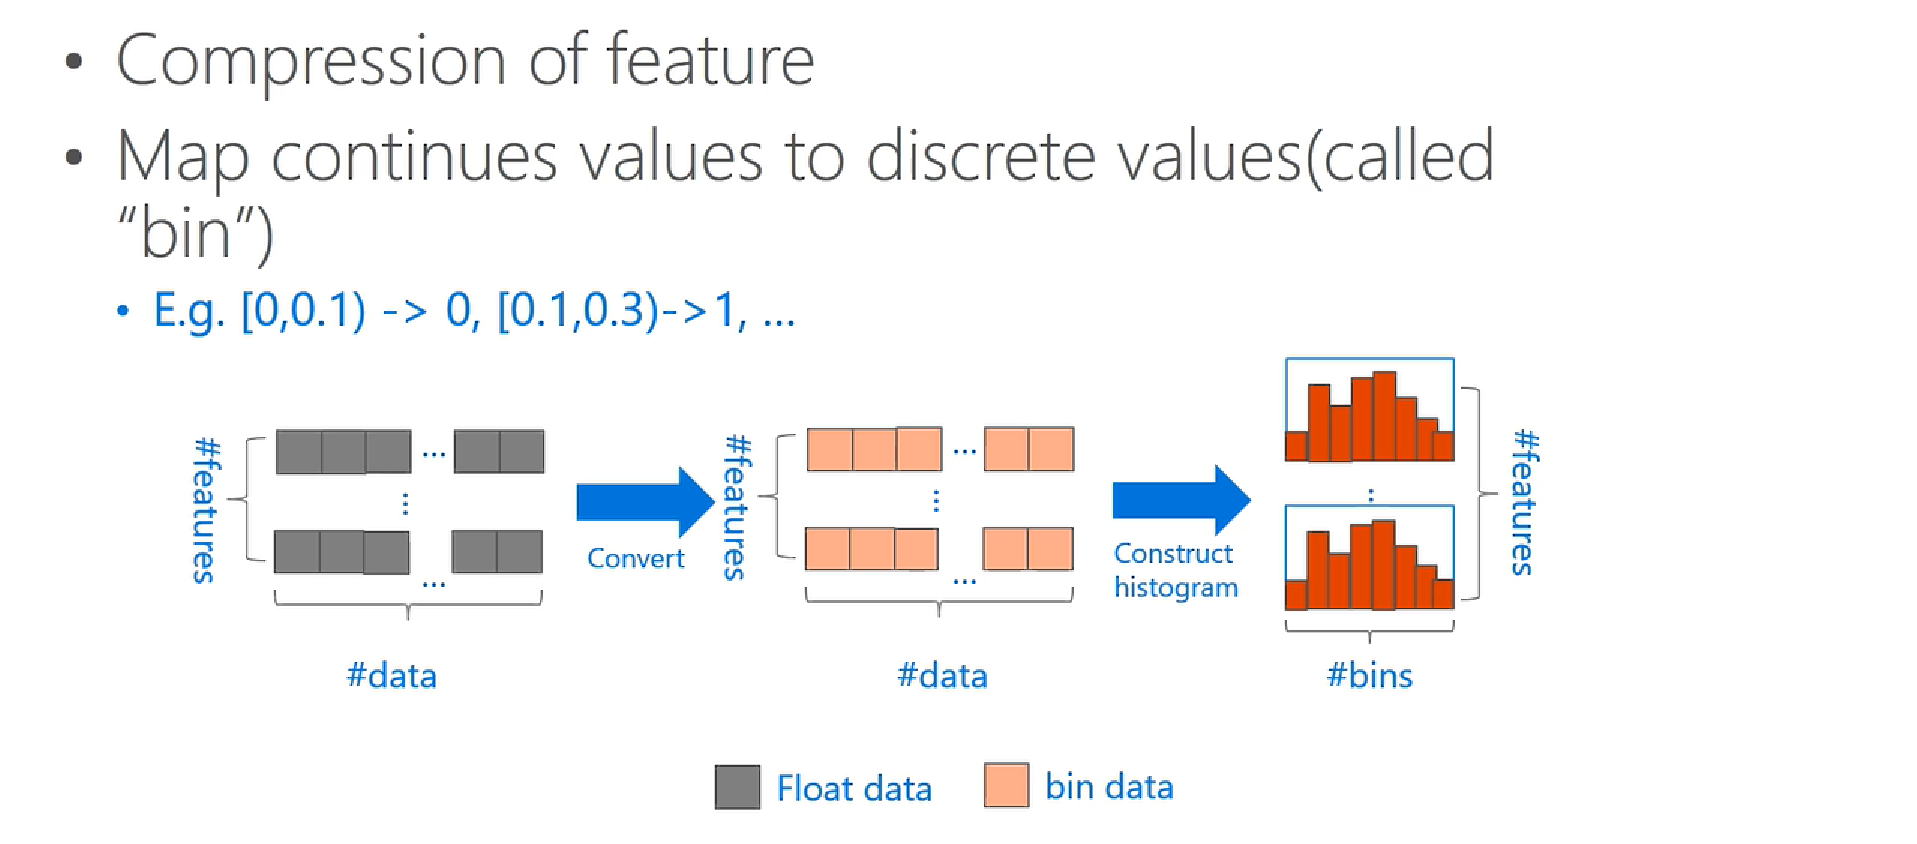
直方图算法简单理解为：首先确定对于每一个特征需要多少个箱子(bin)并为每一个箱子分配一个整数；然后将浮点数的范围均分成若干区间，区间个数与箱子个数相等，将数据该箱子的样本数据更新为箱子的值；最后将直方图(#bins)表示。

我们知道特征离散化有很多优点，如存储方便、运算更快、鲁棒性强、模型更加为稳定等。对于直方图算法来说最直接的有以下两个优点：

- 内存占用更小：直方图算法不仅不需要额外存储预排序的结果，而且可以只保存特征离散化后的值，而这个值一般用8位整型存储就足够了，内存消耗可以降低为原来的1/8。也就是说Xgboost需要用32位的浮点数去存储特征值，并用32位的整形去存储索引，而lightGBM只需要用8位去存储直方图，内存相当于减少位1/8。
- 计算代价更小：预排序算法XGboost每遍历一个特征值就需要计算一次分类的增益，而直方图算法lightGBM只需要计算k次(k可以认为是常数)，直接将时间复杂度从O(#data#feature)降低到O(k*#feature)，而我们知道#data>>k。

(2) 直方图做差加速

LightGBM另一个优化是Histogram（直方图）做差加速。一个叶子的直方图可以由它的父亲结点的直方图与它兄弟的直方图做差得到，在速度上可以提升一倍。通常构造直方图时，需要遍历该叶子上的所有数据，但直方图做差仅需遍历直方图的k个桶。在实际构建树的过程中，LightGBM还可以先计算直方图小的叶子结点，然后利用直方图做差来获得直方图大的叶子节点，这样就可以用非常微小的代价得到它兄弟叶子的直方图。
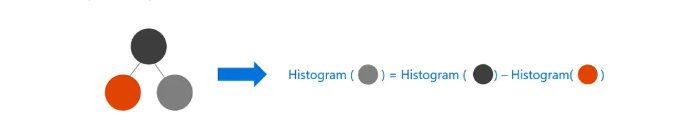



**带深度限制的Leaf-wise算法**

在Histogram算法之上，LightGBM进行进一步的优化。首先它抛弃了大多数GBDT工具使用的按层生长(level-wise)的决策树生长策略，而使用了带有深度限制的按叶子生长(leaf-wise)算法。

XGBoost采用level-wise的增长策略，该策略遍历一次数据可以同时分裂同一层的叶子，统一进行多线程优化，也好控制模型复杂度，不容易过拟合。但实际上Level-wise是一种低效的算法，因为它不加区分的对待同一层的叶子，实际上很多叶子的分裂增益较低，没必要进行搜索和分裂，因此带来了很多没必要的计算开销。

LightGBM采用了leaf-wise的增长策略，该策略每次从当前所有叶子中，找到分裂增益最大的一个叶子，然后分裂，如此循环。因此同level-wise相比，Leaf-wise的优点是：在分裂次数相同的情况下，Leaf-wise可以降低更多的误差，得到更好的精度；Leaf-wise的缺点是：可能会长出比较深的决策树，产生过拟合。因此LightGBm会在Leaf-wise之上增加一个最大深度的限制，在保证高效率的同时防止过拟合。

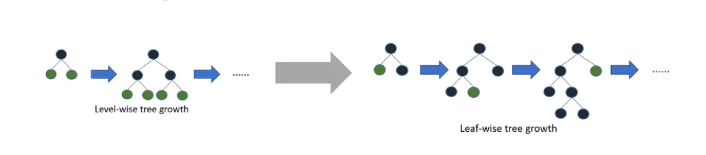

**单边梯度采样算法**

Gradient-based One-Side Samping应该被翻译为单边梯度采样(GOSS)。GOSS算法从减少样本的角度出发，排除大部分小梯度的样本，仅用剩下的样本计算信息增益，它是一种在减少数据量和保证精度上平衡的算法。

Adaboost中，样本权重是数据重要性的指标。然而在GBDT中没有原始样本权重，不能应用权重采样。幸运的是，我们观察到GBDT中每个数据都有不同的梯度值，对采样十分有用。即梯度小的样本，训练误差也比较小，说明数据已经被模型学习的很好了，直接想法就是丢掉这部分梯度小的数据。然而这样做会改变数据的分布，将会影响训练模型的精确度，为了避免此问题，提出了GOSS算法。

GOSS是一个样本的采样算法，目的是丢弃一些对计算信息增益没有磅数的样本留下有帮助的。根据信息增益的定义，梯度大的样本对信息增益由更大的影响。因此，GOSS在进行数据采样的时候只保留了梯度较大的数据，但是如果直接将所有梯度较小的数据都丢弃势必会影响数据的总体分布。所以，GOSS首先将要进行分裂的所有取值按照绝对值大小降序排序，选取绝对值最大的a个数据，然后在剩下的较小梯度数据中随机选择b个数据。接着将这b个数据乘以一个常数(1-a)/b，这样算法就会更关注训练不足的样本，而不会过多改变原数据集的分布。最后使用这(a+b)*100%个数据来计算信息增益。

**互斥特征捆绑算法**

高维度的数据往往是稀疏的，这种稀疏性启发我们设计一种无损的方法来减少特征的维度。通常被捆绑的特征都是互斥的(即特征不会同时为非零值，像one-hot),这样两个特征捆绑起来才不会丢失信息。如果两个特征并不是完全互斥(部分情况下两个特征都是非零值)，可以用一个指标对特征不互斥程度进行衡量，称之为冲突比率，当这个值较小时，我们可以选择把不完全互斥的两个特征捆绑，而不影响最后的精度。互斥特征捆绑算法(Exclusive Feature Bundling,EFB)指出如果将一些特征进行融合绑定，则可以降低特征数量。这样在构建直方图时的时间复杂度从O(#data#feature)变O(#data*#bundle)，这里#bundle指特征融合绑定后特征包的个数，且#bundle远小于#feature。

针对这种想法，我们会遇到两个问题:

- 怎么判定哪些特征应该绑在一起(build bundled)？

- 怎么把特征绑为一个(merge feature)?

（1）解决哪些特征应该绑在一起

将相互独立的特征进行绑定时一个NP-hard问题，LightGBM的EFB算法这个问题转化为图着色的问题来求解，将所有的特征视为图的各个顶点，将不是相互独立的特征用一条边连接起来，边的权重就是两个相连接的特征的总冲突值，这样需要绑定的特征就是在图着色问题中要涂上同一种颜色的那些特征。此外，我们注意到通常由很多特征，尽管不是100%相互排斥，但很少同时取非零值。如果我们的算法可以允许一小部分的冲突，我们可以得到更少的特征包，进一步提高计算效率。算法允许两两特征并不完全互斥来增加特征捆绑的数量，通过设置最大冲突比率来平衡算法的精度和效率。

(2) 解决怎么把特征绑为一捆

特征合并算法，其关键在于原始特征能从合并的特征中分离出来。绑定几个特征在同一个bundle里需要保证绑定前的原始特征的值可以在bundle中识别，考虑到histogram-based算法将连续的值保存为离散的bins，我们可以使得不同特征的值分到bundle中的不同bin中，这可以通过在特征值中加一个偏置常量来解决。比如，我们在bundle中绑定了两个特征A和B，A特征的原始取值为区间[0,10)，B特征的原始取值为区间[0,20)，我们可以在B特征的取值上加一个偏置常量10，将其取值范围变为[10,30)，绑定后的特征取值范围为[0,30),这样就可以放心的融合特征A和B了。

**直接支持类别特征**

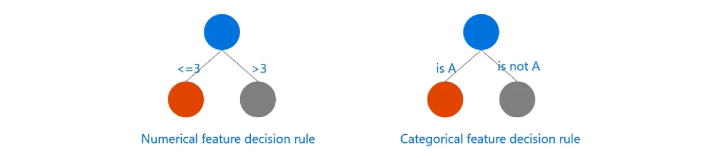

传统的机器学习工具一般不能直接输入类别特征，需要预先做离散化，转换为很多多维的0,1特征，这样的做法无论在时间上还是空间上，效率都不高。

LightGBM通过更改决策树算法的决策规则，直接原生支持类别特征，不需要额外的离散化。并且通过一些实验，MRSA研究人员验证了直接使用离散特征可以比使用0-1离散化后的特征，速度快到8倍以上 。

**支持高效并行**

LightGBM原生支持多种并行算法：

- Feature Parallelizaton适用于小数据且特征比较多的场景；
- Data Parallelization适用于数据量比较大，但特征比较少的场景；
- Voting Parallelization适用于数据量比较大，特征也比较多的场景；

1、特征并行

特征并行主要是并行化决策树中寻找最优划分点(Find Best Split)的过程，这部分最为耗时。

传统算法

传统算法的做法如下：

- 垂直划分数据（对特征划分），不同的worker有不同的特征集
- 每个workers找到局部最佳的切分点{feature, threshold}
- workers使用点对点通信，找到全局最佳切分点
- 具有全局最佳切分点的worker进行节点分裂，然后广播切分后的结果（左右子树的instance indices）
- 其它worker根据收到的instance indices也进行划分

LightGBM中的特征并行

每个worker保存所有的数据集，这样找到全局最佳切分点后各个worker都可以自行划分，就不用进行广播划分结果，减小了网络通信量。过程如下：

- 每个workers找到局部最佳的切分点{feature, threshold}
- workers使用点对点通信，找到全局最佳切分点
- 每个worker根据全局全局最佳切分点进行节点分裂

2、数据并行

传统算法

数据并行目标是并行化整个决策学习的过程：

- 水平切分数据，不同的worker拥有部分数据
- 每个worker根据本地数据构建局部直方图
- 合并所有的局部直方图得到全部直方图
- 根据全局直方图找到最优切分点并进行分裂

- 使用分散规约将不同worker的不同特征的直方图合并，然后workers在局部合并的直方图中找到局部最优划分，最后同步全局最优划分。
- 前面提到过，可以通过直方图作差法得到兄弟节点的直方图，因此只需要通信一个节点的直方图。

3、投票并行

在数据量很大的时候，使用投票并行的方式只合并部分特征的直方图从而达到降低通讯量的目的。

**Cache命中率优化**

XGBoost的Pre-sorted 的算法当中，有两个操作频繁的地方，会造成cache-miss。

- 对梯度的访问，在计算增益的时候，需要利用梯度，但不同的特征访问梯度顺序都是不一样的，而且是随机的。
- 对索引表的访问，pre-sorted使用一个行号和叶子节点号的索引表，所有的特征都要通过访问这个索引表，并且是随机的。这带来了非常大的系统性能的下降。
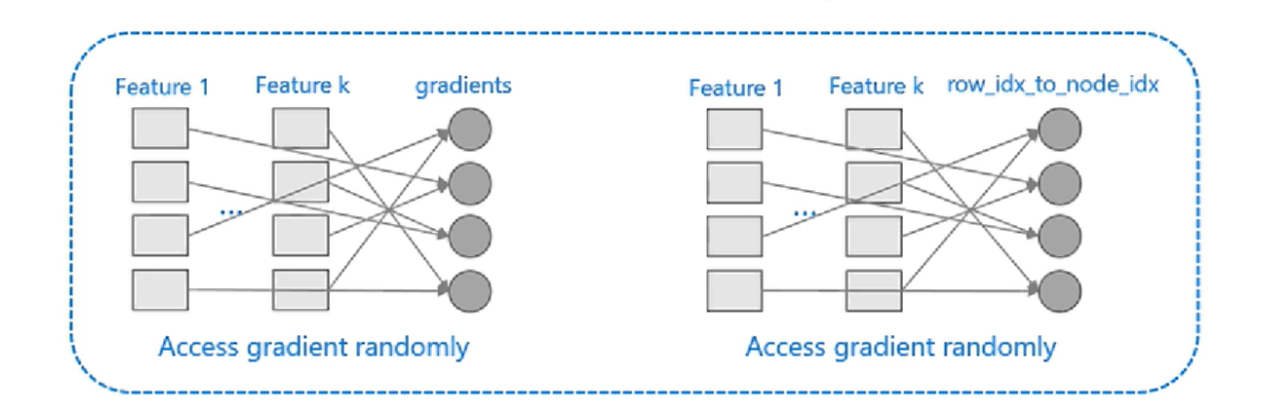

LightGBM使用直方图算法是天然的cache friendly，首先，对梯度的访问，因为不需要对特征进行排序，同时，所有的特征都采用同样的方式进行访问，所以只需要对梯度访问的顺序进行一个重新的排序，所有的特征都能连续地访问梯度。

此外，直方图算法不需要数据id到叶子id的一个索引表，没有cache-miss的问题。事实上，在cache-miss这样一个方面，对速度的影响是很大的，尤其在数据量很大的时候，MRSA研究人员进行过测试，在数据量很多的时候，相比于随机访问，顺序访问的速度可以快4倍以上，这其中速度的差异基本上是由cache-miss带来的。
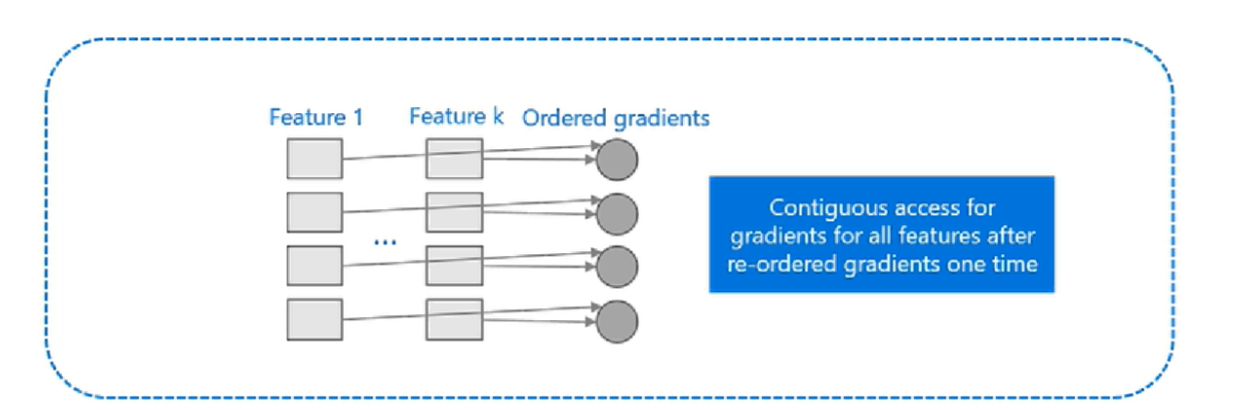

# 数据准备

In [24]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [14]:
#读取数据
data = pd.read_csv("../data/iris.csv")
print(data.head())

   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width Species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


In [15]:
#准备数据
data = data.dropna()
y = data['Species']
x = data.drop(['Species'],axis=1).astype('float64')

# 训练集、测试集划分
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state= 42)

# 模型训练

In [16]:
# 分类模型、参数
model = LGBMClassifier(random_state = 0, verbosity= -1)
param_grid = {'n_estimators': [10, 100, 200], 'max_depth': [5, 10, 20], 'learning_rate': [0.1, 0.001, 0.002]}

# GridSearchCV优化参数、训练模型
gsearch = GridSearchCV(model, param_grid)
model = gsearch.fit(x_train, y_train)

# 打印最优结果
print('DecisionTree params:', model.best_estimator_)

DecisionTree params: LGBMClassifier(max_depth=5, n_estimators=200, random_state=0, verbosity=-1)


In [17]:
lgbm = LGBMClassifier(max_depth=5, n_estimators=200, random_state=0, verbosity=-1)
lgbm.fit(x_train, y_train)
lgbm.feature_importances_ # 特征重要性

array([423, 470, 679, 483])

Text(0, 0.5, 'Feature')

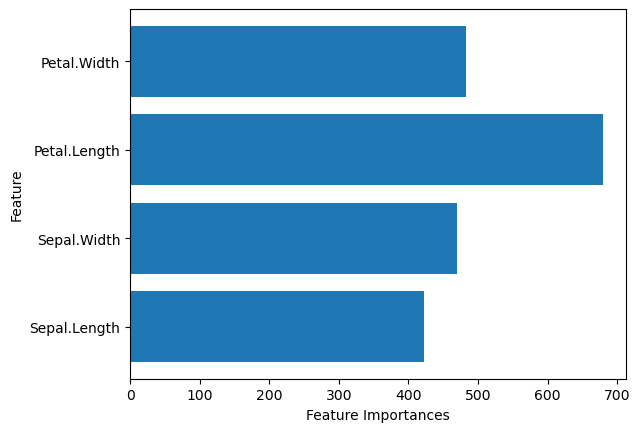

In [18]:
can = {n:v for n,v in zip(data.columns,lgbm.feature_importances_)}
plt.barh(list(can.keys()),list(can.values()),align = 'center')
plt.xlabel("Feature Importances")
plt.ylabel("Feature")

# 模型保存

In [19]:
# 法一
import joblib

# 保存模型
joblib.dump(model, '../outputs/best_models/lgbm.pkl')

# 加载模型
model = joblib.load('../outputs/best_models/lgbm.pkl')

In [20]:
# 法二
import pickle

with open('../outputs/best_models/lgbm.pkl', 'wb') as f:
    pickle.dump(model, f)

#读取Model
with open('../outputs/best_models/lgbm.pkl', 'rb') as f:
    model = pickle.load(f)

# 模型预测

In [21]:
prediction = model.predict(x_test)

In [22]:
# 计算准确率
acc = accuracy_score(y_test, prediction)
print("acc为：", acc)

acc为： 0.9736842105263158


In [23]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.92      1.00      0.96        11
   virginica       1.00      0.92      0.96        12

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38

